In [ ]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

%matplotlib inline

import tensorflow
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/Shareddrives/Machine Learning Project/UTK_Face0521.csv')

In [ ]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


**EDA**

In [ ]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [ ]:
df = df.drop(['img_name','ethnicity'], axis=1)

Text(0.5, 1.0, 'Number of Images by Age in UTK Face Dataset')

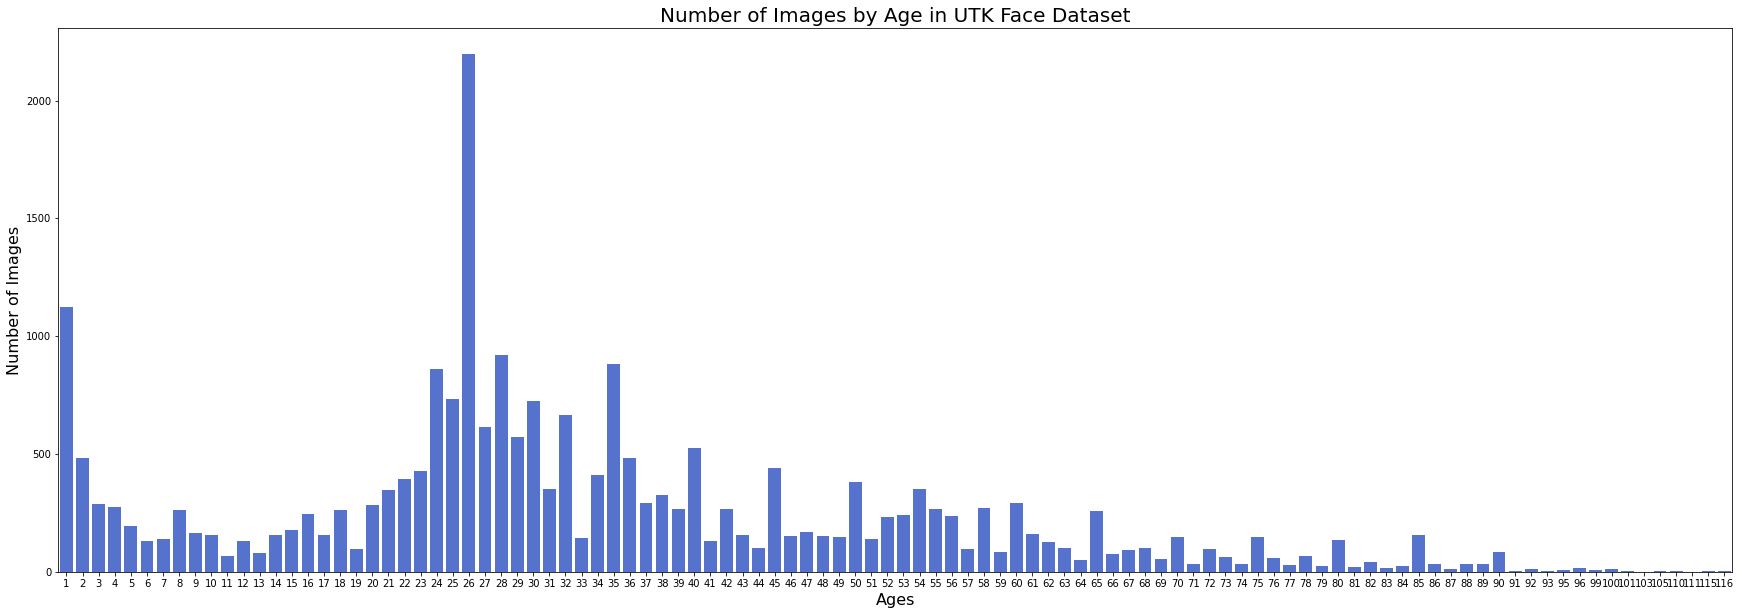

In [ ]:
ages, counts = np.unique(df.age, return_counts=True)
d = dict(zip(ages, counts))
d = {int(k):int(v) for k,v in d.items()}
plt.figure(figsize=(30, 10))
ax = sns.barplot(x=list(d.keys()), y=list(d.values()), color='royalblue')
plt.xlabel("Ages", fontsize=16)
plt.ylabel("Number of Images", fontsize=16)
plt.title("Number of Images by Age in UTK Face Dataset", fontsize=20)

In [ ]:
def class_labels(age):
    if 0 <= age <= 14:
        return 0
    elif 15 <= age <= 24:
        return 1
    elif 25 <= age <= 28:
        return 2
    elif 29 < age <= 33:
        return 3
    elif 34 <= age <= 45:
        return 4
    elif 46 <= age <= 60:
        return 5
    else:
        return 6
# 

In [ ]:
df['target'] = df['age'].map(class_labels)

In [ ]:
df.head()

,age,gender,pixels,target
0,1,0,129 128 128 126 127 130 133 135 139 142 145 14...,0
1,1,0,164 74 111 168 169 171 175 182 184 188 193 199...,0
2,1,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,0
3,1,0,193 197 198 200 199 200 202 203 204 205 208 21...,0
4,1,0,202 205 209 210 209 209 210 211 212 214 218 21...,0


In [ ]:
num_pixels = len(df['pixels'][0].split(' '))
img_height = np.sqrt(num_pixels)
img_width = np.sqrt(num_pixels)

In [ ]:
print(num_pixels, img_height, img_width)

2304 48.0 48.0


In [ ]:
y = df['target']
X = df['pixels']

In [ ]:
X = X.apply(lambda x: x.split(' '))
X = X.apply(lambda x: np.array(list(map(lambda z: np.float(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
X

array([[[129., 128., 128., ..., 118.,  99.,  53.],
        [130., 129., 128., ..., 117.,  98.,  52.],
        [131., 129., 130., ..., 114.,  97.,  50.],
        ...,
        [121., 138., 147., ..., 151., 150., 148.],
        [117., 137., 146., ..., 149., 148., 148.],
        [115., 135., 142., ..., 146., 146., 146.]],

       [[164.,  74., 111., ..., 111., 111., 104.],
        [179.,  70., 128., ..., 112., 113., 108.],
        [176.,  71., 146., ..., 112., 112., 109.],
        ...,
        [192., 196., 235., ..., 111., 124., 112.],
        [230., 226., 233., ..., 198., 197., 180.],
        [238., 239., 233., ..., 182., 170., 148.]],

       [[ 67.,  70.,  71., ..., 197., 194., 192.],
        [ 65.,  66.,  69., ..., 197., 194., 192.],
        [ 61.,  63.,  69., ..., 197., 194., 190.],
        ...,
        [159., 157., 159., ..., 114., 105., 105.],
        [102., 114., 110., ..., 114., 110., 107.],
        [ 98.,  97.,  95., ..., 112., 111., 108.]],

       ...,

       [[ 59.,  50.,  37

In [ ]:
X.shape

(23705, 48, 48)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:

num_classes = 7
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(X_train.shape)
print(y_train.shape)

(16593, 48, 48)
(16593, 7)


In [ ]:

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

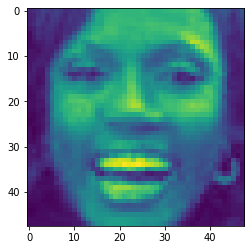

In [ ]:
plt.imshow(X_train[0].reshape(48, 48))

**Traditional ML(XGBoost)**

Creating instance of XGB classifier and reshaping the training data:

In [ ]:
XGB = XGBClassifier(random_state=42)

In [ ]:
X_train.shape

(16593, 48, 48, 1)

In [ ]:
X_train1 = X_train.reshape(16593, (48*48))

In [ ]:
df1 = pd.DataFrame(y_train, columns = ['Group_1','Group_2','Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7'])

In [ ]:
df1.head(5)

,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df1.loc[df1["Group_2"] == 1, "Group_2"] = 2
df1.loc[df1["Group_3"] == 1, "Group_3"] = 3
df1.loc[df1["Group_4"] == 1, "Group_4"] = 4
df1.loc[df1["Group_5"] == 1, "Group_5"] = 5
df1.loc[df1["Group_6"] == 1, "Group_6"] = 6
df1.loc[df1["Group_7"] == 1, "Group_7"] = 7

In [ ]:
y_train1 = df1.to_numpy()

In [ ]:
y_train1.shape

(16593, 7)

In [ ]:
y_train1 = y_train1.reshape(16593*7,1)

In [ ]:
y_train1.shape

(116151, 1)

In [ ]:
y_train1 = y_train1[y_train1 != 0]

In [ ]:
y_train1.shape

(16593,)

In [ ]:
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
rs_model=RandomizedSearchCV(XGB,param_distributions=params,cv=3,verbose=3)

In [ ]:
rs_model.fit(X_train1,y_train1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7;, score=0.420 total time= 2.7min
[CV 2/3] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7;, score=0.445 total time= 2.7min
[CV 3/3] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=7;, score=0.435 total time= 2.7min
[CV 1/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=7;, score=0.441 total time=14.7min
[CV 2/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=7;, score=0.447 total time=14.6min
[CV 3/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=7;, score=0.435 total time=14.6min
[CV 1/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5;, score=0.421 total time= 7.3min
[CV 2/3] END colsam

RandomizedSearchCV(cv=3, estimator=XGBClassifier(random_state=42),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   verbose=3)

In [ ]:
XGB_best = XGBClassifier(random_state=42, colsample_bytree= .5, gamma = .2, learning_rate = .15, max_depth= 10 , min_child_weight= 1)

In [ ]:
XGB_best.fit(X_train1,y_train1)

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=10,
              objective='multi:softprob', random_state=42)

In [ ]:
y_train_pred = XGB_best.predict(X_train1)

In [ ]:
train_accuracy = accuracy_score(y_train1,y_train_pred)

In [ ]:
print(train_accuracy)

0.9969866811305972


In [ ]:
X_test.shape

(7112, 48, 48, 1)

In [ ]:
X_test1 =X_test.reshape(7112, (48*48))

In [ ]:
X_test1.shape

(7112, 2304)

In [ ]:
df_ytest = pd.DataFrame(y_test, columns = ['Group_1','Group_2','Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7'])

In [ ]:
df_ytest.head(2)

,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_ytest.loc[df_ytest["Group_2"] == 1, "Group_2"] = 2
df_ytest.loc[df_ytest["Group_3"] == 1, "Group_3"] = 3
df_ytest.loc[df_ytest["Group_4"] == 1, "Group_4"] = 4
df_ytest.loc[df_ytest["Group_5"] == 1, "Group_5"] = 5
df_ytest.loc[df_ytest["Group_6"] == 1, "Group_6"] = 6
df_ytest.loc[df_ytest["Group_7"] == 1, "Group_7"] = 7

In [ ]:
y_test1 = df_ytest.to_numpy()

In [ ]:
y_test1.shape

(7112, 7)

In [ ]:
y_test1 = y_test1.reshape(7112*7,1)

In [ ]:
y_test1 = y_test1[y_test1 != 0]

In [ ]:
y_pred = XGB_best.predict(X_test1)

In [ ]:
accuracy = accuracy_score(y_test1, y_pred)

In [ ]:
print(accuracy)

0.44474128233970756


In [ ]:
cf_matrix = confusion_matrix(y_test1, y_pred)

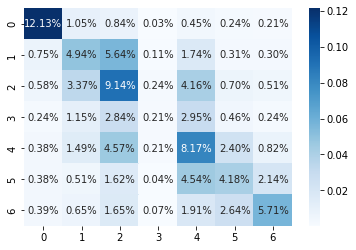

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
cmd_obj = ConfusionMatrixDisplay(cf_matrix, display_labels=['1-14', '15-24', '25-28', '29-33', '34-45','46-60', '60+'])

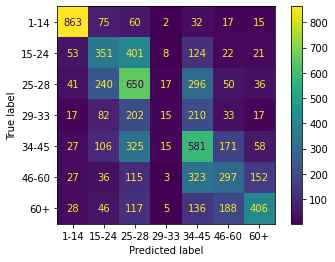

In [ ]:
cmd_obj.plot()